# Tests

## Introduction

Cet exemple présente un notebook python créé avec jupyterlab dont la première cellule inclue ce contenu en _MarkDown_. Ce notebook peut être alors inclus avec mkdocs dans un site web comme une page parfaitement intégrée (à la place d'un fichier .md).

Les cellules suivantes contiennent du code (python) interprété par le jupyter notebook ainsi que leurs résultats.


## Exemple simple

Afficher "Bonjour le monde en anglais"

In [1]:
print("Hello World")

Hello World


## Utilisation de numpy et matplotlib

L'exemple ci-dessous, qui affiche deux graphiques, est repris du site de la librairie [matplotlib](https://matplotlib.org/2.0.2/users/pyplot_tutorial.html#working-with-multiple-figures-and-axes)

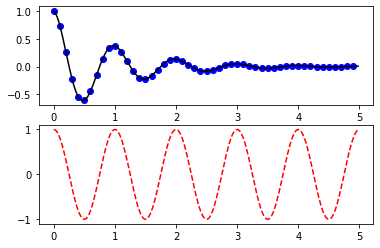

In [2]:
#import numpy, matplot lib et affiche un graphique de base
import numpy as np
import matplotlib.pyplot as plt

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()

## Utilisation d'une trame exportée de la caméra OAK-D

L'exemple ci-dessous lit la trame 100 d'un fichier enregistré avec la [caméra OAK-D](https://shop.luxonis.com/products/oak-d) et qui a été convertie avec le programme `convert.py`du _Starter Kit_ en images couleurs _jpg_ et en fichier _csv depth_ grâce à la commande ```python convert.py -f "test.hdf5" -o "imgs"```. L'ensemble de ces fichiers est contenu dans le dossier imgs du dossier du _Starter Kit_ donc `src`.

### Ouverture fichier image et profondeur 

Notons que l'importation d'opencv est nécessaire en plus de numpy et matplotlib importé dans l'exemple précédent, donc plus nécessaire de réimporter !

In [3]:
import cv2
file_fmt = '%05d'             # format des fichiers images avec 5 chiffres 
file_dir = '../../src/imgs'   # répertoire des fichiers
frame_nb = 100                # numéro de la trame à lire
fcolor = file_dir+'/'+file_fmt+'.jpg'   
fdepth = file_dir+'/'+file_fmt+'.depth.csv'
# lis l'image couleur en jpg 
color = cv2.imread(fcolor % frame_nb)
# charge la profondeur
depth = np.genfromtxt(fdepth % frame_nb,delimiter=',')

### Affichage de l'image couleur

_Opencv_ ne peut pas être utilisé pour afficher l'image dans Jupyter. Il est donc nécessaire d'utiliser _matplotlib_. Toutefois, _Opencv_ utilise l'image en BGR (_Blue Green Red_) et _matplotlib_ en RGB.
Il convient donc de convertir l'image couleur BGR en RGB

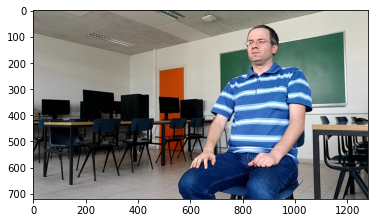

In [4]:
# conversion de BGR à RGB en utilisant l'index incrémental -1 sur la troisième dimension
rgb = color[:,:,::-1] 
plt.imshow(rgb)
plt.show()

### Récupération des informations de conversion/exportation

Lors de la conversion en fichiers images et profondeurs, le programme `convert.py` génère un fichier _json_ nommé _export.json_ dans le dossier de conversion. Ce fichier contient diverses informations sur l'exportation mais également les inforamtions relatives au fichier HDF5 de l'enregistrement d'origine que nous pouvons utiliser par la suite

In [5]:
import json
jsfile = file_dir+'/export.json'
jsf = open(jsfile,'r')
exportdata = json.load(jsf)
fileinfo = exportdata['info']  # info contient les informations du fichier d'enregistrement
maxRange = fileinfo['maxRange'] # on récupère maxRange
jsf.close()   #on ferme le fichier json par sécurité
print('maxRange =',maxRange)

maxRange = 15000


### Affichage de l'image de profondeur

L'image de profondeur est une matrice de valeurs donnant la distance en mm en chaque pixel (0 pour une valeur invalide, donc la profondeur n'a pu être déterminée). Afin de pouvoir afficher cette image de profondeur comme dans les fonctions `record.py` et `play.py`, nous allons effectuer une conversion de cette distance en une image "couleur" des valeurs de profondeur sur une distance maximale avec une palette, plus précisémment _HOT_ (correspondance d'une valeur dans un range de 0 à 255 à une couleur de la palette). 

Afin de nous aider dans cette tâche, la fonction _depthtorg_ est définie dans laquelle nous spécifions la distance maximale (couleur devra être noire) et la matrice de profondeur.

In [6]:
# définition d'une fonction convertissant la profondeur en une image en utilisant la palette HOT (cf. dans process.py)
def depthtorgb(depth, maxRange):
    tmpd = np.minimum(maxRange, depth)
     # noir pour les objets lointains et blanc pour les valeurs invalides de profondeur (0--> 255)
    frameDepth = 255 - ((tmpd * 255. / maxRange)).astype(np.uint8)
    # application de la color map hot (blanc valeur élevée et noir valeur faible)
    frameDepth = cv2.applyColorMap(frameDepth, cv2.COLORMAP_HOT)
    # retourne l'image en la convertissant de BRG à RGB !
    return frameDepth[:,:,::-1]

Avec le code ci-dessous utilisant la fonction précédente, l'image de profondeur est affichée sur la distance maximale définie par _maxRange_, donc 15m dans cet exemple.

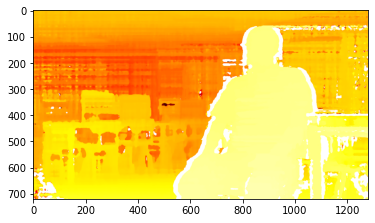

In [7]:
rgb_depth = depthtorgb(depth, maxRange)
plt.imshow(rgb_depth)
plt.show()

Une distance inférieure peut être également spécifiée, par exemple 3m, au delà de laquelle, l'image de profondeur est alors noire avec la palette _HOT_ sélectionnée.

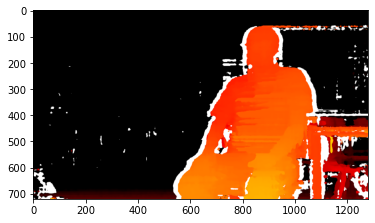

In [8]:
rgb_depth = depthtorgb(depth, 3000)
plt.imshow(rgb_depth)
plt.show()

**Avec l'image précédente, nous voyons que la modification de la valeur maximale de profondeur permet de percevoir plus facilement les variations de distances proches. Une autre fonction similaire pourrait effectuer cette conversion en considérant également une distance minimale (_minRange_) où les points à distance inférieure seraient donc blancs.**